In [1]:
import pandas as pd
import numpy as np

import sys
sys.path.insert(0, '/Users/AlexH/utils')

from utils.plot import *
from utils.data import *

%matplotlib inline

In [2]:
def get_int_col(x):
    try:
        return int(x[0])
    except:
        return x[1]

def convert_to_int(x):
    try:
        return int(x)
    except:
        return 0

In [3]:
df = pd.read_csv('titanic_train.csv')

df['title'] = df['Name'].str.split(', ', expand=True)[1].str.split('. ', expand=True)[0]

a = df['Ticket'].str.split(' ', expand=True).apply(get_int_col, axis=1)
df['ticket_num'] = a.fillna(0).apply(convert_to_int)

a = df['Cabin'].fillna('missing').str.split(' ', expand=True)[0]
df['cabin_letter'] = a.apply(lambda x: x[0]).replace('m', 'missing')

In [4]:
df1 = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], 1)
df1.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,title,ticket_num,cabin_letter
0,0,3,male,22.0,1,0,7.2500,S,Mr,21171,missing
1,1,1,female,38.0,1,0,71.2833,C,Mrs,17599,C
2,1,3,female,26.0,0,0,7.9250,S,Miss,3101282,missing
3,1,1,female,35.0,1,0,53.1000,S,Mrs,113803,C
4,0,3,male,35.0,0,0,8.0500,S,Mr,373450,missing


In [91]:
df2 = pd.get_dummies(df1).fillna(0)
df2 = df2.drop(['title_Col', 'title_Don', 'title_Jonkheer', 'title_Sir'], 1)

X = df2[df2.columns.difference(['Survived'])]
y = df2['Survived']

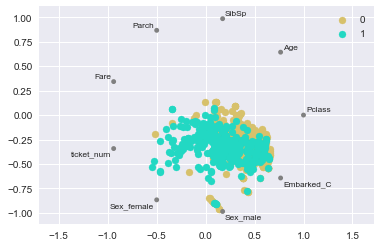

In [97]:
from pandas.plotting import radviz, parallel_coordinates

radviz(df2.iloc[:, :10], 'Survived')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

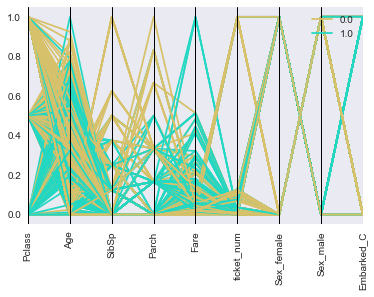

In [110]:
s = StandardScaler()
s = MinMaxScaler()
dfpc = pd.DataFrame(s.fit_transform(df2), columns=df2.columns)

parallel_coordinates(dfpc.iloc[:, [0] + range(1,10)], 'Survived')
plt.xticks(rotation=90)

# projections

In [36]:
def plot_decomp(model):
    decomp = make_pipeline(StandardScaler(), model)
    comps = decomp.fit_transform(df2.drop('Survived', 1))[:, :2]
    newdf = cbind(df2, comps).rename(columns={0: 'pca1', 1: 'pca2'})

    newdf.pipe((sns.lmplot, 'data'), x='pca1', y='pca2', hue='Survived', fit_reg=False)

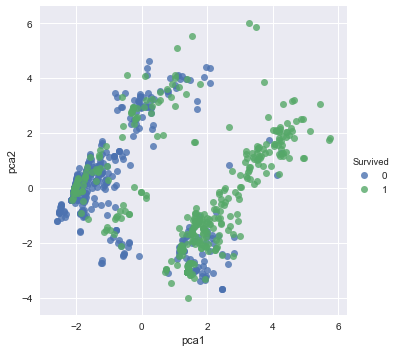

In [37]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.pipeline import make_pipeline

plot_decomp(PCA())

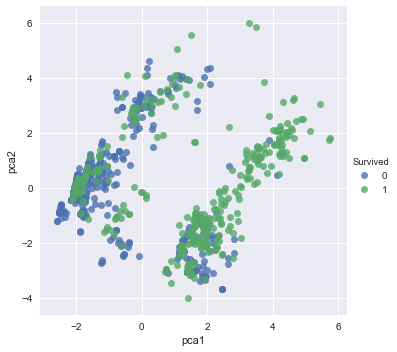

In [38]:
plot_decomp(TruncatedSVD())

In [30]:
from sklearn.manifold import Isomap, LocallyLinearEmbedding, MDS, SpectralEmbedding, TSNE, \
    locally_linear_embedding, spectral_embedding

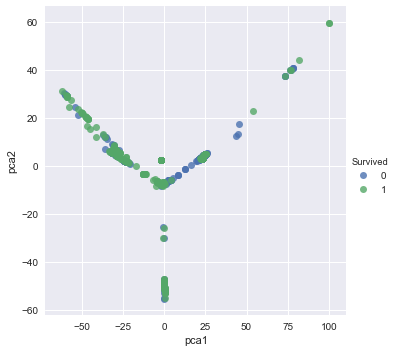

In [39]:
plot_decomp(Isomap())

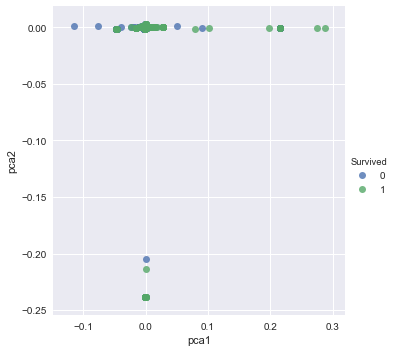

In [40]:
plot_decomp(LocallyLinearEmbedding())

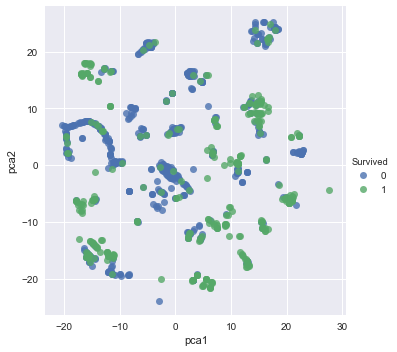

In [41]:
plot_decomp(TSNE())

# models

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X, y, random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [70]:
from sklearn.linear_model import LogisticRegression

models = [make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression()),
          make_pipeline(StandardScaler(), TruncatedSVD(), LogisticRegression()),
          make_pipeline(StandardScaler(), Isomap(), LogisticRegression()),
          make_pipeline(StandardScaler(), LocallyLinearEmbedding(), LogisticRegression())]

for model in models:
    print cross_val_score(model, xtrain, ytrain, scoring='roc_auc', cv=cv).mean()

0.837549728325
0.837549728325
0.644098275455
0.5607805339


In [71]:
from sklearn.ensemble import RandomForestClassifier

models = [make_pipeline(StandardScaler(), PCA(n_components=2), RandomForestClassifier()),
          make_pipeline(StandardScaler(), TruncatedSVD(), RandomForestClassifier()),
          make_pipeline(StandardScaler(), Isomap(), RandomForestClassifier()),
          make_pipeline(StandardScaler(), LocallyLinearEmbedding(), RandomForestClassifier())]

for model in models:
    print cross_val_score(model, xtrain, ytrain, scoring='roc_auc', cv=cv).mean()

0.818754547602
0.8118010867
0.780366643043
0.758642097803


In [72]:
from sklearn.ensemble import GradientBoostingClassifier

models = [make_pipeline(StandardScaler(), PCA(n_components=2), GradientBoostingClassifier()),
          make_pipeline(StandardScaler(), TruncatedSVD(), GradientBoostingClassifier()),
          make_pipeline(StandardScaler(), Isomap(),GradientBoostingClassifier()),
          make_pipeline(StandardScaler(), LocallyLinearEmbedding(), GradientBoostingClassifier())]

for model in models:
    print cross_val_score(model, xtrain, ytrain, scoring='roc_auc', cv=cv).mean()

0.843554925585
0.8380713442
0.813289865344
0.696559414127


# model interpretation

In [95]:
model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(xtrain, ytrain)

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [96]:
sorted(zip(xtrain.columns, model.steps[1][1].coef_[0]), key=lambda x: abs(x[1]), reverse=True)

[('SibSp', -0.5783053407547889),
 ('title_Mr', -0.56420359803743381),
 ('title_Master', 0.55996262129521091),
 ('Pclass', -0.42342937395547164),
 ('Sex_female', 0.39815565551940474),
 ('Sex_male', -0.39815565551940474),
 ('title_Mrs', 0.38619940274955222),
 ('title_Rev', -0.35324022581775877),
 ('Fare', 0.32546897826433507),
 ('Parch', -0.30065669899074243),
 ('cabin_letter_E', 0.25259096175579621),
 ('title_Major', 0.20116843519673794),
 ('title_Capt', -0.18466857822261676),
 ('cabin_letter_D', 0.16413982676038352),
 ('title_Mlle', 0.16315240844505063),
 ('title_Ms', 0.16268947209726334),
 ('cabin_letter_T', -0.15716052573736558),
 ('title_Lady', 0.14943303506184208),
 ('Embarked_S', -0.14709527061940028),
 ('cabin_letter_missing', -0.13928850089803751),
 ('cabin_letter_G', -0.11556134619686345),
 ('title_th', 0.11177251620082505),
 ('cabin_letter_C', -0.10541691283497842),
 ('cabin_letter_B', 0.1024607683451577),
 ('title_Mme', 0.09883992707175121),
 ('Age', -0.092266811279497332),
 

In [111]:
model = GradientBoostingClassifier()
model.fit(xtrain, ytrain)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [113]:
sorted(zip(xtrain.columns, model.feature_importances_), key=lambda x: abs(x[1]), reverse=True)

[('ticket_num', 0.29380796441943402),
 ('Fare', 0.20523420016767621),
 ('Age', 0.12759591802542611),
 ('title_Mr', 0.09214343562504855),
 ('SibSp', 0.039587593015899987),
 ('Pclass', 0.031466958427974603),
 ('title_Master', 0.021994398824915051),
 ('cabin_letter_E', 0.020631285008367955),
 ('Parch', 0.020189015603057858),
 ('Sex_male', 0.018362391806714343),
 ('Embarked_S', 0.016707355412399615),
 ('title_Mrs', 0.015229124706664035),
 ('cabin_letter_missing', 0.013813950979655718),
 ('Sex_female', 0.012757818111756277),
 ('title_Dr', 0.010589507796295623),
 ('cabin_letter_D', 0.010585813746732993),
 ('title_Rev', 0.0087542499226884),
 ('cabin_letter_B', 0.0086058479353063339),
 ('title_Major', 0.0085877905008089183),
 ('title_Miss', 0.0083994970678755079),
 ('title_Capt', 0.0058824175801795373),
 ('cabin_letter_C', 0.0041425536612599264),
 ('cabin_letter_A', 0.0034248308982148656),
 ('Embarked_Q', 0.0015060807556476197),
 ('Embarked_C', 0.0),
 ('cabin_letter_F', 0.0),
 ('cabin_letter_G